#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, 1 pst, X enzymes, one sample per instance, multiple enzymes per instance, test how many enzymes can have in one instances, how computing time depends on N p::f for 60 samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [55]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['e_activity']

,enzyme,sample,value,prob
0,e1,s1,inc,0.667479
1,e1,s10,dec,0.869338
2,e1,s100,inc,0.962838
3,e1,s11,base,0.883589
4,e1,s12,dec,0.708652
...,...,...,...,...
295,e3,s95,inc,0.763878
296,e3,s96,inc,0.912364
297,e3,s97,inc,0.681275
298,e3,s98,dec,0.735379


In [56]:
# duplicate data['e_activity'] * n and replace e1 in the new df with en
# use pd.concat
n = 8 # doesn't work for n > 7, maybe inconsistent evidence error because the samples are completely random?!
new_act = data['e_activity'].copy()
for i in range(1, n):
    new_enz = data['e_activity'].loc[data['e_activity']['enzyme'] == f'e1'].copy()
    new_enz['enzyme'] = new_enz['enzyme'].replace('e1', 'e' + str(i+3))
    new_act = pd.concat([new_act, new_enz], ignore_index=True)
new_act

,enzyme,sample,value,prob
0,e1,s1,inc,0.667479
1,e1,s10,dec,0.869338
2,e1,s100,inc,0.962838
3,e1,s11,base,0.883589
4,e1,s12,dec,0.708652
...,...,...,...,...
995,e10,s95,dec,0.917158
996,e10,s96,base,0.830064
997,e10,s97,dec,0.586687
998,e10,s98,inc,0.852893


Splitting data into training/testing

In [57]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.6))
print(train)
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = new_act[new_act['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = data['p_occupancy'][data['p_occupancy']['sample'].isin(train)].reset_index(drop=True)

['s34', 's33', 's72', 's79', 's77', 's75', 's99', 's2', 's5', 's44', 's89', 's28', 's100', 's16', 's58', 's65', 's17', 's54', 's63', 's18', 's84', 's35', 's73', 's95', 's30', 's6', 's68', 's70', 's71', 's39', 's66', 's94', 's20', 's91', 's81', 's31', 's69', 's82', 's50', 's86', 's22', 's1', 's3', 's25', 's85', 's90', 's64', 's96', 's27', 's9', 's23', 's78', 's98', 's32', 's4', 's53', 's29', 's51', 's87', 's14']


In [58]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [59]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
evidence_dict = {}
for s in samples:
    evidence = []
    for predicate in predicates:
        evid_generator = build.ProblogStatementGenerator(predicates[predicate])
        evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    evidence_dict[s] = evidence

In [60]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o6.pl', 'w') as f:
    for s in evidence_dict:
        for e in evidence_dict[s]:
            f.write(e + '\n')
        f.write('--------------------' + '\n')

LFI

In [ ]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o6.pl {DIR}evidence_o6.pl -O {DIR}p_model_o6.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

Grounding

In [32]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o6.pl -o {DIR}p_model_o6_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s29)::e_activity(e1,s29,dec); t(0.33,e1,s29)::e_activity(e1,s29,inc).\n0.001::e_ksea(e1,s29,inc) :- e_activity(e1,s29,dec).\n0.5316::e_ksea(e1,s29,inc) :- e_activity(e1,s29,inc).\nt(0.33,e2,s29)::e_activity(e2,s29,dec); t(0.33,e2,s29)::e_activity(e2,s29,inc).\n0.5316::e_ksea(e2,s29,dec) :- e_activity(e2,s29,dec).\n0.001::e_ksea(e2,s29,dec) :- e_activity(e2,s29,inc).\nt(0.33,e3,s29)::e_activity(e3,s29,dec); t(0.33,e3,s29)::e_activity(e3,s29,inc).\n0.5316::e_ksea(e3,s29,dec) :- e_activity(e3,s29,dec).\n0.001::e_ksea(e3,s29,dec) :- e_activity(e3,s29,inc).\nt(0.33,e4,s29)::e_activity(e4,s29,dec); t(0.33,e4,s29)::e_activity(e4,s29,inc).\n0.001::e_ksea(e4,s29,inc) :- e_activity(e4,s29,dec).\n0.5316::e_ksea(e4,s29,inc) :- e_activity(e4,s29,inc).\nt(0.33,e5,s29)::e_activity(e5,s29,dec); t(0.33,e5,s29)::e_activity(e5,s29,inc).\n0.001::e_ksea(e5,s29,inc) :- e_activity(e5,s29,dec).\n0.5316::e_ksea(e5,s29,inc) :- e_activity(e5,s29,inc).\nt(0.33,e6,s29)::e_activity(e6,s29,dec); t(

256

Analysis

In [4]:
n_evidence =  np.array([4, 5, 6, 7, 8, 9, 10])
n_enz = np.array([3, 4, 5, 6, 7, 8, 9])
n_pfacts = np.array([21, 26, 31, 36, 41, 46, 51])
n_pfacts_e = np.array([25, 31, 37, 43, 49, 55, 61])
n_params = np.array([28, 34, 40, 46, 52, 58, 64])
t_compile = np.array([2.134700, 2.510404, 2.775359, 3.771901, 5.508517, 9.106901, 18.386029])
t_total = np.array([6.0, 9.3, 16.2, 41.6, 159.8, 391.0, 1227.9])

Compare with o3

In [5]:
n_evidence_o3 = np.array([4, 5, 6, 7, 8])
n_enz_o3 = np.array([3, 4, 5, 6, 7])
n_pfacts_o3 = np.array([32, 39, 46, 53, 60])
n_pfacts_e_o3 = np.array([36, 44, 52, 60, 68])
n_params_o3 = np.array([54, 63, 72, 81, 90])
n_pfacts_cross_o3 = np.array([17, 20, 23, 26, 29])
n_params_cross_o3 = np.array([33, 36, 39, 42, 45])
t_compile_o3 = np.array([4.116558, 5.509027, 7.889339, 14.196261, 30.153538])
t_total_o3 = np.array([37.5, 101.8, 339.5, 1116.6, 3197.5])
t_eval_o3 = t_total - t_compile

Plot F

In [6]:
x_features_f = {'2-valued variables': n_enz, '3-valued variables': n_enz_o3}
y_time_f = {'2-valued variables': t_total, '3-valued variables': t_total_o3}
# viz.plot_multiple_time_exp(x_features, y_time, 'Enzymes per instance', 'Total time [s]', 8, title=None)

2-valued variables - Predicted y-value for x = 8: 406.8765077455763s = 6.781275129092938min = 0.11302125215154897h
3-valued variables - Predicted y-value for x = 8: 9433.78377083457s = 157.22972951390952min = 2.6204954918984917h


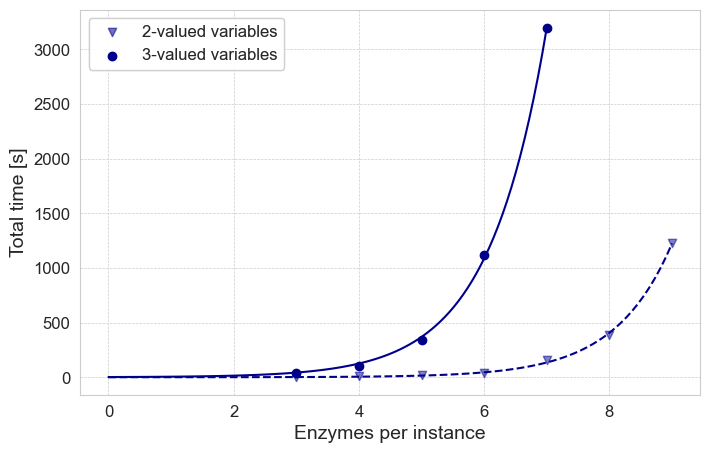

In [7]:
def plot_multiple_time_exp_f(x_features, y_time, x_label, y_label, x_predict, title = 'Exponential Fit'):
    
    def exponential_func(x, a, b):
        return a * np.exp(b * x)

    initial_guess = [1.0, 0.1]

    custom_labels = []
    custom_handles = []

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization

    for i, (key, feature) in enumerate(x_features.items()):

        # Define color based on key
        if "2" in key:
            linestyle = '--'
            alpha = 0.5
            marker = 'v'
        elif "3" in key:
            linestyle = '-'
            alpha = 1
            marker = 'o'

        params, covariance = curve_fit(exponential_func, feature, y_time[key], p0=initial_guess)
        y_predict = exponential_func(x_predict, *params)

        # Calculate R^2
        residuals = y_time[key] - exponential_func(feature, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_time[key] - np.mean(y_time[key]))**2)
        r_squared = 1 - (ss_res / ss_tot)

        plt.scatter(feature, y_time[key], label=f'{key}', marker=marker, alpha=alpha, color='darkblue')
        x_range = np.linspace(0, max(feature), 100)  # Use the common x-range
        line, = plt.plot(x_range, exponential_func(x_range, *params), color='darkblue', linestyle=linestyle, linewidth=1.5)  # Get line for color

        # Collect custom labels and handles
        custom_labels.append(f'R^2={r_squared:.4f}')
        custom_handles.append(line)

        print(f'{key} - Predicted y-value for x = {x_predict}: {y_predict}s = {y_predict/60}min = {y_predict/3600}h')

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Create the first legend for the line labels
    legend1 = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    # Add the first legend manually to the current Axes
    plt.gca().add_artist(legend1)
    # Create the second legend for the custom labels
    # plt.legend(custom_handles, custom_labels, loc='upper left', bbox_to_anchor=(0, 0.85), fontsize=12)

    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

plot_multiple_time_exp_f(x_features_f, y_time_f, 'Enzymes per instance', 'Total time [s]', 8, title=None)

In [8]:
x_features_g = {'2-valued variables (Prob. facts)': n_enz, '3-valued variables (Prob. facts)': n_enz_o3, '2-valued variables (Parameters)': n_enz, '3-valued variables (Parameters)': n_enz_o3}
y_features_g = {'2-valued variables (Prob. facts)': n_pfacts, '3-valued variables (Prob. facts)': n_pfacts_o3, '2-valued variables (Parameters)': n_params, '3-valued variables (Parameters)': n_params_o3}
# viz.plot_multiple_time_lin(x_features, y_features, 'Enzymes per instance', 'Probabilistic facts / Parameters (in ground model)', 8)

Predicted y-value for x = 8: 46.0s = 0.7666666666666667min = 0.012777777777777779h
Predicted y-value for x = 8: 67.0s = 1.1166666666666667min = 0.01861111111111111h
Predicted y-value for x = 8: 58.0s = 0.9666666666666667min = 0.01611111111111111h
Predicted y-value for x = 8: 99.0s = 1.65min = 0.0275h


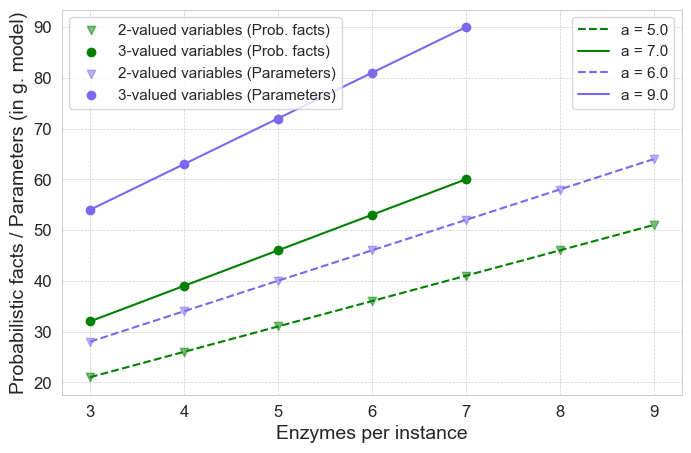

In [12]:
def plot_multiple_time_lin_g(x_dict, y_data_dict, x_label, y_label, x_predict, title = 'Linear Fit'):
    
    # Define the linear function you want to fit
    def linear_func(x, a, b):
        return a * x + b

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization
    
    custom_labels = []
    custom_handles = []
    
    for i, (key, x_data) in enumerate(x_dict.items()):

        # Define color based on key
        if "3" in key:
            linestyle = '-'
            alpha = 1
            marker='o'
        elif "2" in key:
            linestyle = '--'
            alpha = 0.5
            marker='v'

        # Define color based on key
        if "Prob. facts" in key:
            color = 'green'
        elif "Parameters" in key:
            color = 'mediumslateblue'

        y_data = y_data_dict[key]
        # Fit the linear function to the data
        params, covariance = curve_fit(linear_func, x_data, y_data)

        # Parameters of the fitted linear function
        a_fit, b_fit = params

        # Predict y-value
        y_predict = linear_func(x_predict, a_fit, b_fit)

        # Calculate R^2
        residuals = y_data - linear_func(x_data, a_fit, b_fit)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Plot the original data
        plt.scatter(x_data, y_data, label=f'{key}', color=color, alpha=alpha, marker=marker)
        x_range = np.linspace(min(x_data), max(x_data), 100)
        line, = plt.plot(x_range, linear_func(x_range, a_fit, b_fit), color=color, linestyle=linestyle, linewidth=1.5)  # Get line for color

        # Collect custom labels and handles
        custom_labels.append(f'a = {a_fit:.1f}')
        custom_handles.append(line)

        print(f'Predicted y-value for x = {x_predict}: {y_predict}s = {y_predict/60}min = {y_predict/3600}h')

    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Create the first legend for the line labels
    legend1 = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=11)
    # Add the first legend manually to the current Axes
    plt.gca().add_artist(legend1)
    # Create the second legend for the custom labels
    plt.legend(custom_handles, custom_labels, loc='upper right', fontsize=11)

    plt.grid(True, linestyle='--', linewidth=0.5)
    # plt.xticks(np.arange(2, max(x_data) + 1, 2.0))
    plt.show()

plot_multiple_time_lin_g(x_features_g, y_features_g, 'Enzymes per instance', 'Probabilistic facts / Parameters (in g. model)', 8)

In [13]:
n_combi = np.array([8, 16, 32, 64, 128, 256, 512])
n_combi_o3 = np.array([27, 81, 243, 729, 2187])

In [14]:
x_features_h = {'2-valued variables': n_enz, '3-valued variables': n_enz_o3}
y_features_h = {'2-valued variables': n_combi, '3-valued variables': n_combi_o3}
# viz.plot_multiple_time_exp(x_features, y_features, 'Enzymes per instance', 'Parameter combinations (in ground model)', 8)

2-valued variables - Predicted y-value for x = 8: 256.0000000000001s = 4.266666666666668min = 0.07111111111111114h
3-valued variables - Predicted y-value for x = 8: 6561.000000000006s = 109.35000000000011min = 1.8225000000000018h


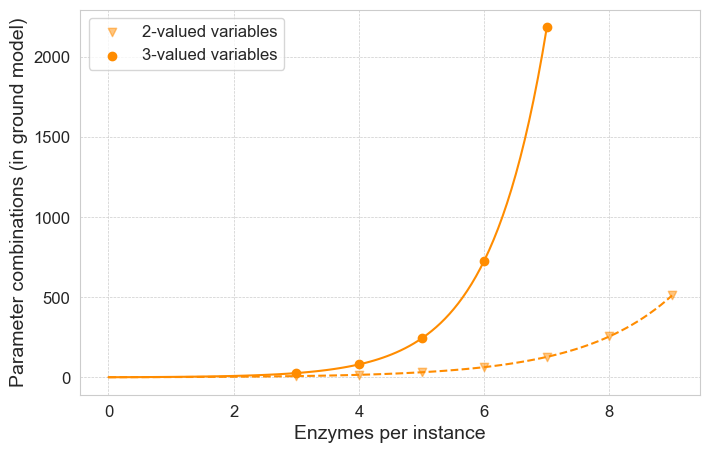

In [15]:
def plot_multiple_time_exp_h(x_features, y_time, x_label, y_label, x_predict, title = 'Exponential Fit'):
    
    def exponential_func(x, a, b):
        return a * np.exp(b * x)

    initial_guess = [1.0, 0.1]

    custom_labels = []
    custom_handles = []

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization
    
    for i, (key, feature) in enumerate(x_features.items()):

        # Define color based on key
        if "2" in key:
            linestyle = '--'
            alpha = 0.5
            marker = 'v'
        elif "3" in key:
            linestyle = '-'
            alpha = 1
            marker = 'o'

        params, covariance = curve_fit(exponential_func, feature, y_time[key], p0=initial_guess)
        y_predict = exponential_func(x_predict, *params)

        # Calculate R^2
        residuals = y_time[key] - exponential_func(feature, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_time[key] - np.mean(y_time[key]))**2)
        r_squared = 1 - (ss_res / ss_tot)

        plt.scatter(feature, y_time[key], label=f'{key}', marker=marker, alpha=alpha, color='darkorange')
        x_range = np.linspace(0, max(feature), 100)  # Use the common x-range
        line, = plt.plot(x_range, exponential_func(x_range, *params), color='darkorange', linestyle=linestyle, linewidth=1.5)  # Get line for color

        # Collect custom labels and handles
        custom_labels.append(f'R^2={r_squared:.4f}')
        custom_handles.append(line)

        print(f'{key} - Predicted y-value for x = {x_predict}: {y_predict}s = {y_predict/60}min = {y_predict/3600}h')

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Create the first legend for the line labels
    legend1 = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    # Add the first legend manually to the current Axes
    # plt.gca().add_artist(legend1)
    # Create the second legend for the custom labels
    # plt.legend(custom_handles, custom_labels, loc='upper left', bbox_to_anchor=(0, 0.85), fontsize=12)

    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

plot_multiple_time_exp_h(x_features_h, y_features_h, 'Enzymes per instance', 'Parameter combinations (in ground model)', 8)